In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from deap import creator, base, tools, algorithms
from scoop import futures
import random
import numpy as np
from scipy import interpolate
# import matplotlib.pyplot as plt



In [2]:
# Read in data from CSV
dfData = pd.read_csv('../data/Wednesday-workingHours-withoutInfinity-Sampled.pcap_ISCX.csv')

print(dfData.groupby(' Label').size())

 Label
0    5000
1    5500
2    5500
3    5499
4    5796
dtype: int64


In [3]:
# change dfData column order
column = list(dfData.columns.values)
column.remove(' Destination IP')
column.remove(' Timestamp')
column.insert(2, ' Destination IP')
column.insert(3, ' Timestamp')

dfData = dfData[column]

In [4]:
# Encode the classification labels to numbers
# Get classes and one hot encoded feature vectors
le = LabelEncoder()
le.fit(dfData[' Label'])
allClasses = le.transform(dfData[' Label'])
allFeatures_full = dfData.drop([' Label'], axis=1)

# omit the first 4 features
allFeatures = allFeatures_full.iloc[:,4:]

In [5]:
# normalize
from sklearn.preprocessing import normalize

allFeatures = pd.DataFrame(normalize(allFeatures, axis=1, copy=True, return_norm=False), columns=column[4:-1])

In [6]:
## every value goes up by 1, due to the chi2 condition
allFeatures += 1

In [7]:
## need improvise because of chi squared
np.shape(allFeatures)
# (allFeatures<0).sum()

(27295, 80)

In [9]:
# Form training, test, and validation sets
X_trainAndTest, X_validation, y_trainAndTest, y_validation = train_test_split(allFeatures, allClasses, test_size=0.20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_trainAndTest, y_trainAndTest, test_size=0.20, random_state=42)

In [10]:
# X_train = X_train[:6400]
# X_test = X_test[:1600]
# y_train = y_train[:6400]
# y_test = y_test[:1600]
# X_trainAndTest = X_trainAndTest[:8000]
# X_validation = X_validation[:2000]
# y_trainAndTest = y_trainAndTest[:8000]
# y_validation = y_validation[:2000]

In [11]:
## original lr

In [12]:
from sklearn import svm
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

# clf_svm = svm.SVC()
# clf_svm.fit(X_train, y_train)

# y_pred = clf_svm.predict(X_train)
# acc = metrics.accuracy_score(y_train, y_pred)
# print("Training score: {}".format(acc))

clf_svm = LogisticRegression()
clf_svm.fit(X_train, y_train)

y_pred = clf_svm.predict(X_train)
acc = metrics.accuracy_score(y_train, y_pred)
print("Training score: {}".format(acc))

Training score: 0.8660980077856653


In [13]:
y_pred = clf_svm.predict(X_validation)
acc = metrics.accuracy_score(y_validation, y_pred)
print("Validation score: {}".format(acc))

Validation score: 0.8670086096354643


In [14]:
## filtered lr

In [15]:
## Filter Chi-squared
from sklearn.feature_selection import chi2
from math import isnan
import operator

temp = chi2(X_train, y_train)

dict_temp = {}
for i in range(len(temp[0])):
    if not isnan(temp[0][i]):
        dict_temp[str(i)] = temp[0][i]
        
sorted_dict_temp = sorted(dict_temp.items(), key=operator.itemgetter(1))
column = list(dfData.columns.values)

In [16]:
# go through all possible # of features
k = [index for index in range(1,81)]

from collections import defaultdict
test_acc = defaultdict(list)
train_acc = defaultdict(list)
val_acc = defaultdict(list)

In [17]:
from sklearn.feature_selection import SelectKBest

for item in k:
    test = SelectKBest(score_func=chi2, k=item)
    fit = test.fit(X_train, y_train)

    # summarize scores
    # np.set_printoptions(precision=3)
    # print(fit.scores_)

    X_train_v1 = fit.transform(X_train)
    X_test_v1 = fit.transform(X_test)
    X_validation_v1 = fit.transform(X_validation)

    # summarize selected features
    # print(X_train_v1[0:5,:])
    
    clf = LogisticRegression()
    clf.fit(X_train_v1, y_train)

    y_pred = clf.predict(X_train_v1)
    train = metrics.accuracy_score(y_train, y_pred)
    train_acc[item].append(train) 
    
    y_pred = clf.predict(X_test_v1)
    test = metrics.accuracy_score(y_test, y_pred)
    test_acc[item].append(test) 
    
    y_pred = clf.predict(X_validation_v1)
    validation = metrics.accuracy_score(y_validation, y_pred)
    val_acc[item].append(validation)

In [36]:
# max(val_acc, key=(lambda key: val_acc[key]))
# val_acc
max_val_value = max(val_acc.values())
max_val_keys = [k for k, v in val_acc.items() if v == max_val_value] # getting all keys containing the `maximum`
print("MAX Validation Acc: ")
print(max_val_value, max_val_keys)

validation acc: 
[0.8675581608353178] [60, 61, 65, 68, 70]


In [39]:
# max_test_value = max(test_acc.values())
# max_test_keys = [k for k, v in test_acc.items() if v == max_test_value] # getting all keys containing the `maximum`
# print("MAX Test Acc: ")
# print(max_test_value, max_test_keys)

Test Acc: 
[0.8804945054945055] [34, 35, 36]


In [40]:
# max_train_value = max(train_acc.values())
# max_train_keys = [k for k, v in train_acc.items() if v == max_train_value] # getting all keys containing the `maximum`
# print("MAX Train Acc: ")
# print(max_train_value, max_train_keys)

MAX Train Acc: 
[0.8663842454774444] [54]


In [20]:
# np.shape(allFeatures)[1]

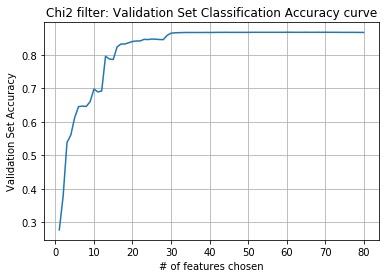

In [44]:
import matplotlib.pyplot as plt

g = plt.figure(1)
plt.plot(list(val_acc.keys()), list(val_acc.values()))
plt.title('Chi2 filter: Validation Set Classification Accuracy curve')
plt.xlabel('# of features chosen')
plt.ylabel('Validation Set Accuracy')
plt.grid()